In [1]:
# 그래픽 카드 둘로 쓰기 (두개 있을때, 하나만 있다면 0)
# gpu idx 를 0 또는 1 로 설정하시오
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(1) # gpu idx

In [2]:
# 경로에 폴더가 없으면 폴더 만들기
import os

def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [3]:
import numpy as np
import itertools
import pickle

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm

EPOCH = 200
KERNEL_SIZE = 3
POOLING_SIZE = 2
BATCH_SIZE = 128

DATA_PATH = "./mit_data/"

def list_to_list(input_list):
    input_list_to_list = list(itertools.chain(*input_list))
    return input_list_to_list

# 데이터 불러오기

In [4]:
# Dataload part
le = preprocessing.LabelEncoder()

record_list = []
pickle_input = dict()
X, y = [], []

print("[INFO] Read records file from ", DATA_PATH)
with open(DATA_PATH + 'RECORDS') as f:
    record_lines = f.readlines()

for i in range(len(record_lines)):
    record_list.append(str(record_lines[i].strip()))

for i in tqdm(range(len(record_list))):
    temp_path = DATA_PATH + "mit" + record_list[i] + ".pkl"
    with open(temp_path, 'rb') as f:
        pickle_input = pickle.load(f)
        for i in range(len(pickle_input[0])):
            X.append(pickle_input[0][i])

        for i in range(len(pickle_input[1])):
            check_ann = pickle_input[1][i]
            temp_ann_list = list()
            if check_ann == "N":            # Normal
                temp_ann_list.append(0)

            elif check_ann == "S":          # Supra-ventricular
                temp_ann_list.append(1)

            elif check_ann == "V":          # Ventricular
                temp_ann_list.append(2)

            elif check_ann == "F":          # False alarm
                temp_ann_list.append(3)

            else:                           # Unclassed 
                temp_ann_list.append(4)
            y.append(temp_ann_list)



[INFO] Read records file from  ./mit_data/


100%|██████████| 48/48 [00:01<00:00, 43.62it/s]


In [5]:
# 데이터 갯수 파악
# N, S, V, F, Q
uni, cnt = np.unique(y, return_counts=True)
print(uni, cnt)

[0 1 2 3 4] [90631  2781  7236   803 11148]


# 데이터 split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42, shuffle=True )

npx = np.array(X_train)
npy = np.array(y_train)
npx_vali = np.array(X_val)
npy_vali = np.array(y_val)
npx_test = np.array(X_test)
npy_test = np.array(y_test)

print("[SIZE]\t\tNpX lenght : {}\n\t\tNpY length : {}".format(npx.shape, npy.shape))
print("[SIZE]\t\tX_validation length : {}\n\t\ty_validation length : {}".format(npx_vali.shape, npy_vali.shape))
print("[SIZE]\t\tX_test length : {}\n\t\ty_test length : {}".format(npx_test.shape, npy_test.shape))

[SIZE]		NpX lenght : (75441, 428)
		NpY length : (75441, 1)
[SIZE]		X_validation length : (12263, 428)
		y_validation length : (12263, 1)
[SIZE]		X_test length : (24895, 428)
		y_test length : (24895, 1)


In [7]:
npyy = np.array(y)
uni, cnt = np.unique(npyy, return_counts=True)
print(uni, cnt)

[0 1 2 3 4] [90631  2781  7236   803 11148]


In [10]:
uni, cnt = np.unique(npy, return_counts=True)
print(uni, cnt)

[0 1 2 3 4] [60577  1892  4884   533  7555]


In [9]:
uni, cnt = np.unique(npy_vali, return_counts=True)
print(uni, cnt)

[0 1 2 3 4] [9929  280  771   85 1198]


In [11]:
uni, cnt = np.unique(npy_test, return_counts=True)
print(uni, cnt)

[0 1 2 3 4] [20125   609  1581   185  2395]


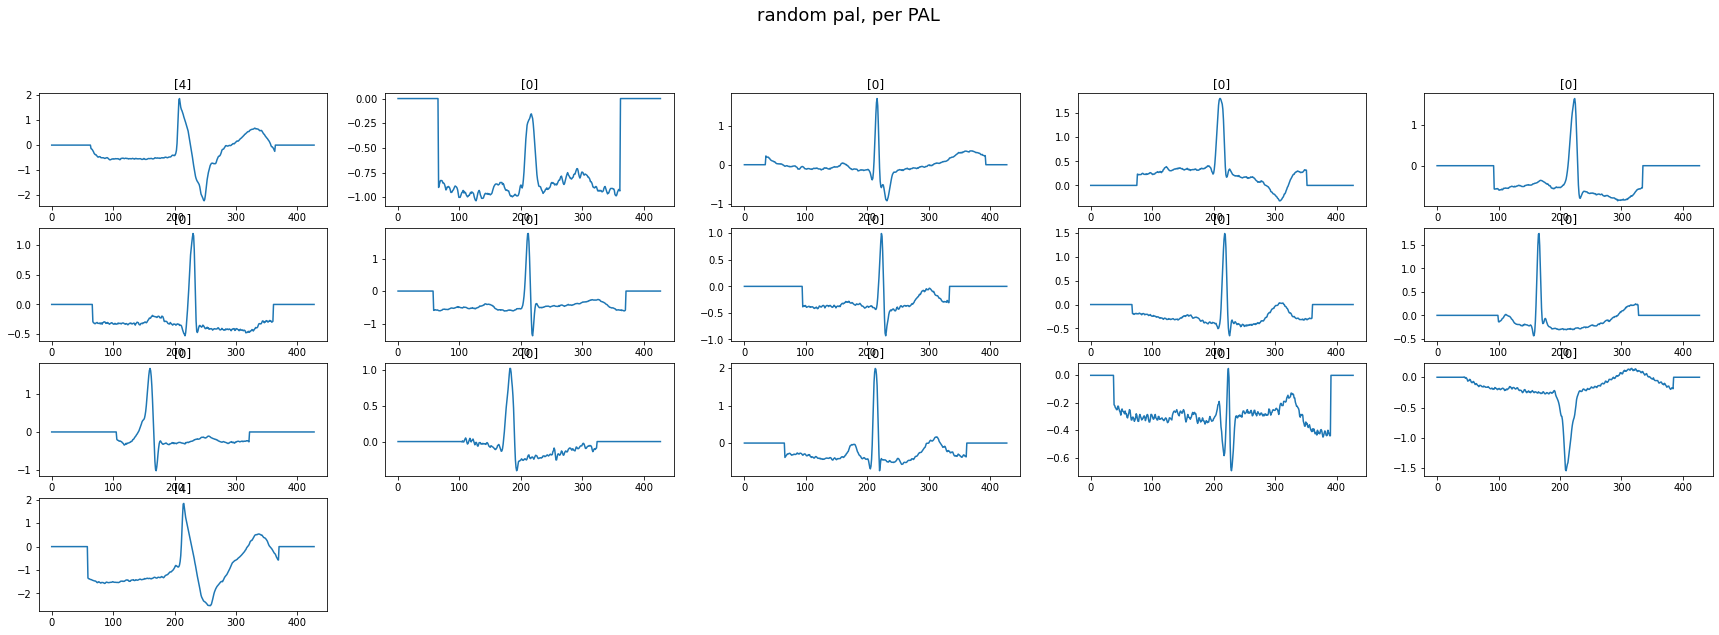

In [16]:
# 랜덤으로 뽑아서 뿌려보기

import matplotlib.pyplot as plt
import random
%matplotlib inline

plt.figure(figsize=(30, 12))
plt.suptitle("random pal, per PAL", fontsize=18)
n = 0
random.seed(11)
for i in random.sample(range(6480), 16):
    ax = plt.subplot(5, 5, n+1)
    plt.plot(npx[i])
    ax.set_title(str(npy[i]))
    n+=1

# 모델 생성

In [17]:
lefms = keras.Sequential([
    layers.Conv1D(32, 3, padding='same', input_shape=(428, 1)),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),

    layers.Conv1D(64, 3, padding='same'),
    layers.Conv1D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(64, 3, padding='same'),
    layers.Conv1D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(128, 3, padding='same'),
    layers.Conv1D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(128, 3, padding='same'),
    layers.Conv1D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(256, 3, padding='same'),
    layers.Conv1D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),
    
    layers.Conv1D(256, 3, padding='same'),
    layers.Conv1D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation(keras.activations.relu),
    layers.MaxPool1D(pool_size=(2), strides=2),

    layers.Reshape((1, 1536)),
    layers.Dropout(0.5),
    layers.GRU(1536),
    layers.Dense(192, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [19]:
lefms.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 428, 32)           128       
_________________________________________________________________
batch_normalization (BatchNo (None, 428, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 428, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 428, 64)           6208      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 428, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 428, 64)           256       
_________________________________________________________________
activation_1 (Activation)    (None, 428, 64)           0

In [20]:
lefms.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
)

# train, test, validation data 나누기

In [21]:
# Train
X_train = tf.convert_to_tensor(npx)
X_train = tf.reshape(X_train, [75441, 428, 1])

y_train = tf.convert_to_tensor(npy)
y_train = tf.one_hot(y_train, 5)
y_train = tf.reshape(y_train, [75441, 5])
print("X_train shape : ",X_train.shape)
print("y_train shape",y_train.shape)

# Validation
X_vali = tf.convert_to_tensor(npx_vali)
X_vali = tf.reshape(X_vali, [12263, 428, 1])

y_vali = tf.convert_to_tensor(npy_vali)
y_vali = tf.one_hot(y_vali, 5)
y_vali = tf.reshape(y_vali, [12263, 5])


print("X_validation shape : ", X_vali.shape)
print("y_validation shape : ", y_vali.shape)

# Test
X_test = tf.convert_to_tensor(npx_test)
X_test = tf.reshape(X_test, [24895, 428, 1])

y_test = tf.convert_to_tensor(npy_test)
y_test = tf.one_hot(y_test, 5)
y_test = tf.reshape(y_test, [24895, 5])
print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (75441, 428, 1)
y_train shape (75441, 5)
X_validation shape :  (12263, 428, 1)
y_validation shape :  (12263, 5)
X_test shape :  (24895, 428, 1)
y_test shape :  (24895, 5)


### 콜백 설정

In [23]:
# 콜백 설정
from keras.callbacks import EarlyStopping, ModelCheckpoint

outDir = './cheakpoint/lefms_model/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{val_accuracy:.4f}.h5'
def get_callbacks(patience = 50):
    
    earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=patience)
  
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_accuracy', verbose=1, save_best_only=True, period = 1)
  
    # callbacks = [earlystop, model_checkpoint]     # earlystop 사용하고 싶으면 이거 풀고 아래꺼 주석 처리
    callbacks = [model_checkpoint]

    return callbacks

# 학습하기

In [24]:
callbacks = get_callbacks()

lefms_hist = lefms.fit(X_train, y_train, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCH, 
                        validation_data=(X_vali, y_vali),
                        callbacks = [callbacks])

Epoch 1/200
590/590 [==============================] - 22s 28ms/step - loss: 0.1646 - accuracy: 0.9499 - val_loss: 0.1301 - val_accuracy: 0.9600

Epoch 00001: val_accuracy improved from -inf to 0.96004, saving model to ./cheakpoint/lefms_model\weights-0.9600.h5
Epoch 2/200
590/590 [==============================] - 15s 26ms/step - loss: 0.0719 - accuracy: 0.9787 - val_loss: 0.0834 - val_accuracy: 0.9736

Epoch 00002: val_accuracy improved from 0.96004 to 0.97358, saving model to ./cheakpoint/lefms_model\weights-0.9736.h5
Epoch 3/200
590/590 [==============================] - 15s 26ms/step - loss: 0.0576 - accuracy: 0.9825 - val_loss: 0.2965 - val_accuracy: 0.8933

Epoch 00003: val_accuracy did not improve from 0.97358
Epoch 4/200
590/590 [==============================] - 15s 25ms/step - loss: 0.0525 - accuracy: 0.9842 - val_loss: 0.1207 - val_accuracy: 0.9645

Epoch 00004: val_accuracy did not improve from 0.97358
Epoch 5/200
590/590 [==============================] - 15s 26ms/step - 

# 결과 시각화 하기

In [61]:
# 학습 된 모델의 학습 과정 시각화
import matplotlib.pyplot as plt
def plot_model__hist(hist):
    path = './cheakpoint/lefms/' # loss, accuracy 그래프 저장할 path
    createDirectory(path)

    # loss 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['loss'], color='b', label="Training loss")
    plt.plot(hist.history['val_loss'], color='r', label="Validation loss")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend()
    plt.show()

    # accuracy 추이 그래프로 그려서 저장
    plt.figure(figsize=(6,6))
    plt.style.use("ggplot")
    plt.plot(hist.history['accuracy'], color='b', label="Training accuracy")
    plt.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
    plt.savefig(path + 'model_loss_hist.png')
    plt.legend(loc = "lower right")
    plt.show()

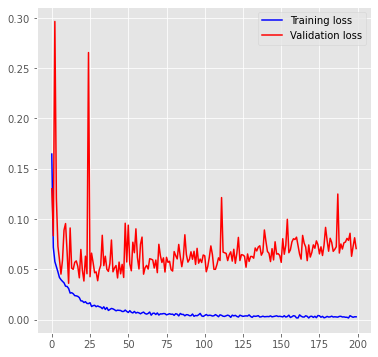

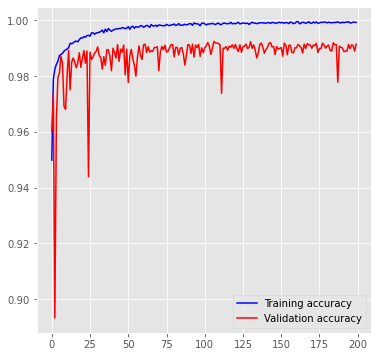

778/778 - 5s - loss: 0.0655 - accuracy: 0.9915
multi_model의 정확도: 99.15%
multi_model의 Loss: 0.0654560849070549


In [62]:
plot_model__hist(lefms_hist)
loss,acc = lefms.evaluate(X_test, y_test, verbose=2)
print("multi_model의 정확도: {:5.2f}%".format(100*acc))
print("multi_model의 Loss: {}".format(loss))

# 모델 불러와서 confusion matrix 그리기

In [28]:
# 모델 불러오기
reconstructed_model = keras.models.load_model("./cheakpoint/lefms_model/weights-0.9924.h5")

In [29]:
# 예측값 얻기
y_pred = reconstructed_model.predict(X_test)

In [30]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y= []
for val in y_test:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y.append(cnt)

In [31]:
# one hat encoding 를 하나의 변수로 바꾸기
new_y_pred = []
for val in y_pred:
    max = 0
    cnt = 0
    for idx, num in enumerate(val):
        if max < num:
            max = num
            cnt = idx + 1
    new_y_pred.append(cnt)

In [32]:
# 최종 정확도 산출
score = reconstructed_model.evaluate(X_test, y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

778/778 [==============================] - 5s 6ms/step - loss: 0.0550 - accuracy: 0.9910
정답률 =  0.990962028503418 loss= 0.054961174726486206


### confusion matrix 그리기

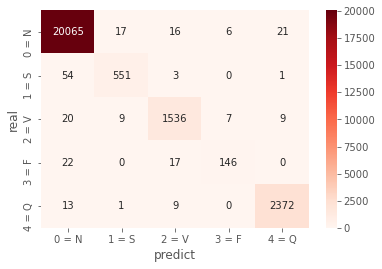

In [33]:
# 개수 버전
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

cm2 = confusion_matrix(new_y, new_y_pred)
sns.heatmap(cm2, annot = True, fmt = 'd', cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

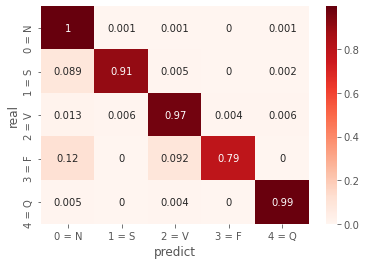

In [52]:
# percentile 버전
total = np.sum(cm2, axis=1)
cm2_percentile = cm2/total[:,None]
sns.heatmap(np.round(cm2_percentile,3), annot = True, cmap= 'Reds')
plt.xlabel('predict')
plt.ylabel('real')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q'])
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix(new_y, new_y_pred)

array([[20065,    17,    16,     6,    21],
       [   54,   551,     3,     0,     1],
       [   20,     9,  1536,     7,     9],
       [   22,     0,    17,   146,     0],
       [   13,     1,     9,     0,  2372]], dtype=int64)

In [35]:
# classification_report 그리기
from sklearn.metrics import classification_report
target_names = ['0 = N', '1 = S', '2 = V', '3 = F', '4 = Q']
print(classification_report(new_y, new_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       0 = N       0.99      1.00      1.00     20125
       1 = S       0.95      0.90      0.93       609
       2 = V       0.97      0.97      0.97      1581
       3 = F       0.92      0.79      0.85       185
       4 = Q       0.99      0.99      0.99      2395

    accuracy                           0.99     24895
   macro avg       0.96      0.93      0.95     24895
weighted avg       0.99      0.99      0.99     24895

